# Image matching with Siamese networks
## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader
import utilities as utils 
from siameseDataloader import readDataFolder, dataSplits,SiameseDataset
from siameseModel import SimpleSiameseNetwork, Resnet20Siamese, Resnet20Binary, MobileNetSiamese, MobilenetBinary
from siameseLosses import ContrastiveLoss

In [2]:
import os
config = utils.load_config()
datadir = os.path.join('data','tiny-imagenet-200-copy','train')#config['DATASET']['root']
numclasses = config['DATASET']['numclasses']
sameprob = config['DATASET']['sameprob']
im_size = config['DATASET']['im_size']
emb_size=config['MODEL']['embsize']

seed = config['seed']
np.random.seed(seed)

device = config['TRAIN']['device']

In [3]:
im_size

32

## Dataset

In [4]:
dataset = readDataFolder(datadir,numclasses)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: data\tiny-imagenet-200-copy\train


In [5]:
train_split,val_split,test_split = dataSplits(dataset,0.8,0.2,0)

In [6]:

train_transforms = transforms.Compose([
    transforms.Resize(im_size+4),
    transforms.RandomCrop(im_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])
test_transforms = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize([0.507, 0.4865, 0.4409], [0.2673, 0.2564, 0.2761])
])

train_dataset = SiameseDataset(train_split,train_transforms,sameprob)
val_dataset = SiameseDataset(val_split,test_transforms,0.5)
test_dataset = SiameseDataset(test_split,test_transforms,0.5)

#train_dataset = torch.load('train_dataset.pkl')
#val_dataset = torch.load('val_dataset.pkl')
#test_dataset = torch.load('val_dataset.pkl')

datasets = {'train':train_dataset,'val':val_dataset,'test':test_dataset}

In [7]:
#torch.save(train_dataset,'train_dataset.pkl')
#torch.save(val_dataset,'val_dataset.pkl')

391
404
404
410
393
392
393
391
386
411
402
394
404
399
429
394
383
389
403
396
398
396
419
410
396
396
398
403
396
408
394
404
405
389
411
383
413
394
399
399
399
402
409
400
402
391
392
391
417
418


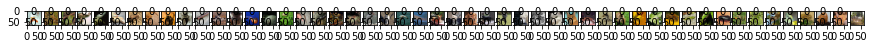

In [8]:
fig,ax=plt.subplots(1,numclasses,figsize=(15,3))
for i in range(numclasses):
    img,num=train_dataset.getImageFromClass(i)
    print(num)
    ax[i].imshow(img)


In [9]:
#dataloaders
dataloaders = {
    'train': DataLoader(train_dataset,shuffle=True,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'val': DataLoader(val_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize']),
    'test': DataLoader(test_dataset,shuffle=False,
                        num_workers=config['TRAIN']['numworkers'],
                        batch_size=config['TRAIN']['batchsize'])
}

In [10]:
for i,data in enumerate(dataloaders['train']):
    print(data[0].shape)
    break

torch.Size([64, 3, 32, 32])


## Model

In [11]:
if config['MODEL']['model'] == 'simple':
    model = SimpleSiameseNetwork(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='resnet':
    model = Resnet20Siamese(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='mobilenet':
    model = MobileNetSiamese(config['MODEL']['distance'],pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='mobilenetbinary':
    model = MobilenetBinary(pretrained=config['MODEL']['pretrained'],embsize=emb_size)
elif config['MODEL']['model'] =='resnetbinary':
    model = Resnet20Binary(pretrained=config['MODEL']['pretrained'],embsize=emb_size)
else:
    model = SimpleSiameseNetwork(config['MODEL']['distance'],embsize=emb_size)

Using cache found in C:\Users\Emilija/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

In [ ]:
data = train_dataset[400]
out = model(data[0].reshape(1,3,im_size,im_size),data[1].reshape(1,3,im_size,im_size))
print(out)
print(data[2])
#print(criterion(out,data[2]))


## Train

In [ ]:
#model.to('cpu')
#model.load_state_dict(model1)

In [12]:
criterion = ContrastiveLoss(margin=config['TRAIN']['lossmargin'])
#criterion = torch.nn.BCELoss()
#config['TRAIN']['lr'] =0.0005
optimizer = optim.Adam(model.parameters(),lr = config['TRAIN']['lr'],weight_decay=0.002)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
for i,data in enumerate(dataloaders['train']):
    label = data[2]
    out = model(data[0],data[1])
    print(out.shape)
    print(data[2].shape)
    #print(torch.dot(torch.pow(out,2).reshape(-1),(1-data[2]).reshape(-1))/64)
    print(criterion(out,label))
    break

In [13]:

model = model.to(device)

In [ ]:
loss_history ={'train':[],'val':[]}
minloss=10000


In [ ]:
best_model = model.state_dict().copy() 

In [ ]:

for epoch in range(config['TRAIN']['numepochs']):
    for mode in ['train','val']:
        loss_epoch=0
        count=0
        for i,(img1,img2,label) in enumerate(dataloaders[mode]):
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)
            
            if mode=='train':
                model.train()
                
                optimizer.zero_grad()
                out = model(img1,img2)
                loss = criterion(out,label)
                loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                with torch.no_grad():
                    out = model(img1,img2)
                    loss = criterion(out,label)
            
            # track total loss
            loss_epoch = loss_epoch+loss
            count = count + len(label)
            
        #scheduler.step()
        
        loss_history[mode].append(loss_epoch.item()/count)
    print('Epoch: {},\t train loss:{:.5},\t val loss:{:.5}'.format(epoch,loss_history['train'][-1],loss_history['val'][-1]))

    if (loss_history['val'][-1] < minloss):
        minloss = loss_history['val'][-1]
        best_model = model.state_dict().copy()
            
            

In [ ]:
model.load_state_dict(best_model)

In [ ]:
plt.figure()
plt.plot(loss_history['train'],'b-')
plt.plot(loss_history['val'],'r-')

## Train acc

In [ ]:
model.eval()
model=model.to(device)
#threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=10)
#threshs = [config['TRAIN']['lossmargin']/2]
threshs=[0.5]
accs = []
sensitivity = []
specificity = []
f1=[]


for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['train']):
        img1=img1.to(device)
        img2=img2.to(device)
        label=label.to(device)
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T*1.,(out>=thresh)*1.)
        conf[1,0] += torch.matmul(label.T*1.,(out<thresh)*1.)
        conf[0,1] += torch.matmul((1-label).T*1.,(out>=thresh)*1.)
        conf[0,0] += torch.matmul((1-label).T*1.,(out<thresh)*1.)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())

In [ ]:
print(accs)
print(f1)

## Val

In [ ]:
loss_epoch = 0
count=0
for i,(img1,img2,label) in enumerate(dataloaders['val']):
    img1 = img1.to(device)
    img2=img2.to(device)
    label = label.to(device)
    with torch.no_grad():
        out = model(img1,img2)
        loss = criterion(out,label)

    # track total loss
    loss_epoch = loss_epoch+loss
    count = count + len(label)
print('Validation loss: {}'.format(loss_epoch.item()/count))

In [ ]:
# Visualise
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    example = val_dataset[i]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,im_size,im_size).to(device),example[1].reshape(1,3,im_size,im_size).to(device))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

In [ ]:
threshs = np.linspace(start=0,stop=config['TRAIN']['lossmargin']*1.2,num=11)
#threshs = [config['TRAIN']['lossmargin']/2]
#threshs = [0.5]
#threshs = np.linspace(start=0,stop=1,num=11)
accs=[]
sensitivity = []
specificity = []
precision = []
f1=[]

num=0
for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['val']):
        img1=img1.to(device)
        img2=img2.to(device)
        label=label.to(device)
        
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T*1.,(out>=thresh)*1.)
        conf[1,0] += torch.matmul(label.T*1.,(out<thresh)*1.)
        conf[0,1] += torch.matmul((1-label).T*1.,(out>=thresh)*1.)
        conf[0,0] += torch.matmul((1-label).T*1.,(out<thresh)*1.)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())
    precision.append((conf[0,0]/(conf[0,0]+conf[1,0])).item())
    
    print(num)
    num += 1

In [ ]:
print(accs)
print(f1)
print(config['TRAIN']['lossmargin']*1.2)

In [ ]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)
precision = np.array(precision)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

In [ ]:
name = "saved\\"+config['MODEL']['model']+"_emb10_"
torch.save(threshs,name+'threshs.pkl')
torch.save(accs,name+'accs.pkl')
torch.save(f1,name+'f1.pkl')
torch.save(specificity,name+'specificity.pkl')
torch.save(sensitivity,name+'sensitivity.pkl')
torch.save(precision,name+'precision.pkl')

## Test

In [ ]:
loss_epoch=0
count=0
for i,(img1,img2,label) in enumerate(dataloaders['test']):
    with torch.no_grad():
        out = model(img1,img2)
        loss = criterion(out,label)

    # track total loss
    loss_epoch = loss_epoch+loss
    count = count + len(label)
print('Test loss: {}'.format(loss_epoch.item()/count))
    

In [ ]:
# Visualise
numex=5 #number of examples
fig,ax = plt.subplots(2,numex,figsize=(15,5))
for i in range(numex):
    example = test_dataset[i]
    utils.imshow(example[0],ax[0][i])
    utils.imshow(example[1],ax[1][i])
    distance = model(example[0].reshape(1,3,64,64),example[1].reshape(1,3,64,64))
    ax[0][i].set_title('label:{},distance:{:.2}'.format(example[2].item(),distance.item()))
plt.show()

In [ ]:
threshs = [1]
accs = []
sensitivity = []
specificity = []
f1=[]


for thresh in threshs:
    pos=0
    neg=0
    conf = np.zeros((2,2))
    for i,(img1,img2,label) in enumerate(dataloaders['test']):
        with torch.no_grad():
            out = model(img1,img2)
        
        conf[1,1] += torch.matmul(label.T,(out>=thresh)*1)
        conf[1,0] += torch.matmul(label.T,(out<thresh)*1)
        conf[0,1] += torch.matmul((1-label).T,(out>=thresh)*1)
        conf[0,0] += torch.matmul((1-label).T,(out<thresh)*1)
        pos = pos + torch.sum(label)
        neg = neg + torch.sum(1-label)

    accs.append(((conf[1,1]+conf[0,0])/(pos+neg)).item())
    sensitivity.append((conf[0,0]/neg).item()) #changed 0 and 1 labels (0 is true in the loss fcn)
    specificity.append((conf[1,1]/pos).item())
    f1.append(((2*conf[0,0])/(2*conf[0,0]+conf[0,1]+conf[1,0])).item())
    break

In [ ]:
accs = np.array(accs)
sensitivity = np.array(sensitivity)
specificity = np.array(specificity)
f1 = np.array(f1)

m1 = np.argmax(accs)
m2 = np.argmax(f1)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(threshs,accs)
ax[0].set_xlabel('threshold')
ax[0].set_ylabel('accuracy')
ax[1].plot(threshs,f1)
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('f1-score')
ax[2].plot(1-specificity,sensitivity,'o',label='_nolabel_')
ax[2].set_xlabel('1-specificity')
ax[2].set_ylabel('sensitivity')
ax[2].plot(1-specificity[m1],sensitivity[m1],'ro',label='acc thresh:{}'.format(threshs[m1]))
ax[2].plot(1-specificity[m2],sensitivity[m2],'go',label='f1 thresh:{}'.format(threshs[m2]))
ax[2].legend()

## Save model

In [ ]:
model = model.to('cpu')
config['MODEL']['modelpath']="models\\mobilenet_state_dict_emb10.pkl"
torch.save(model.state_dict(),config['MODEL']['modelpath'])

# Exctract embeddings

In [14]:
model = model.to(device)
model.eval()

MobileNetSiamese(
  (distance): PairwiseDistance()
  (network): MobileNet(
    (cnn): MobileNetV2(
      (features): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Seque

In [17]:
train_embs = []
train_labels = []
val_embs = []
val_labels = []

In [18]:
for k in range(10):
    for i,(img1,img2,label) in enumerate(dataloaders['train']):
        img1 = img1.to(device)
        img2 = img2.to(device)
        with torch.no_grad():
            out = model.getEmb(img1,img2)

        train_embs+=out.tolist()
        train_labels+=label.detach().tolist()

In [19]:
for k in range(5):
    for i,(img1,img2,label) in enumerate(dataloaders['val']):
        img1 = img1.to(device)
        img2 = img2.to(device)
        with torch.no_grad():
            out = model.getEmb(img1,img2)

        val_embs+=out.tolist()
        val_labels+=label.detach().tolist()

In [20]:
modelname = "saved\\"+config['MODEL']['model']+'_'
torch.save((train_embs,train_labels),modelname+'trainembs.pkl')
torch.save((val_embs,val_labels),modelname+'valembs.pkl')